# Analyzing a spherical harmonics expansion

This notebook will demonstrate how to perform a spherical harmonics expansion of a pointcloud and how to analyze it quantitatively. All parameters are also described in the according [publication](https://www.biorxiv.org/content/10.1101/2021.03.26.437148v1.abstract).

In [1]:
import napari
import napari_stress

import matplotlib.pyplot as plt

In [2]:
# Get some sample data
pointcloud = napari_stress.get_droplet_point_cloud()[0]

In [3]:
viewer = napari.Viewer(ndisplay=3)

Assistant skips harvesting pyclesperanto as it's not installed.


In [4]:
layer_raw = viewer.add_layer(napari.layers.Layer.create(data = pointcloud[0], meta=pointcloud[1], layer_type=pointcloud[2]))

## Spherical harmonics expansion

As explained in [this notebook](./demo_spherical_harmonics.ipynb), a spherical harmonics expansion can be done as follows. Note that this returns a [LayerDataTuple](https://napari.org/stable/api/napari.types.html) with three entries `(data, properties, layer_type)`.

In [5]:
max_degree = 5

In [6]:
fitted_points = napari_stress.fit_spherical_harmonics(pointcloud[0], max_degree=max_degree)

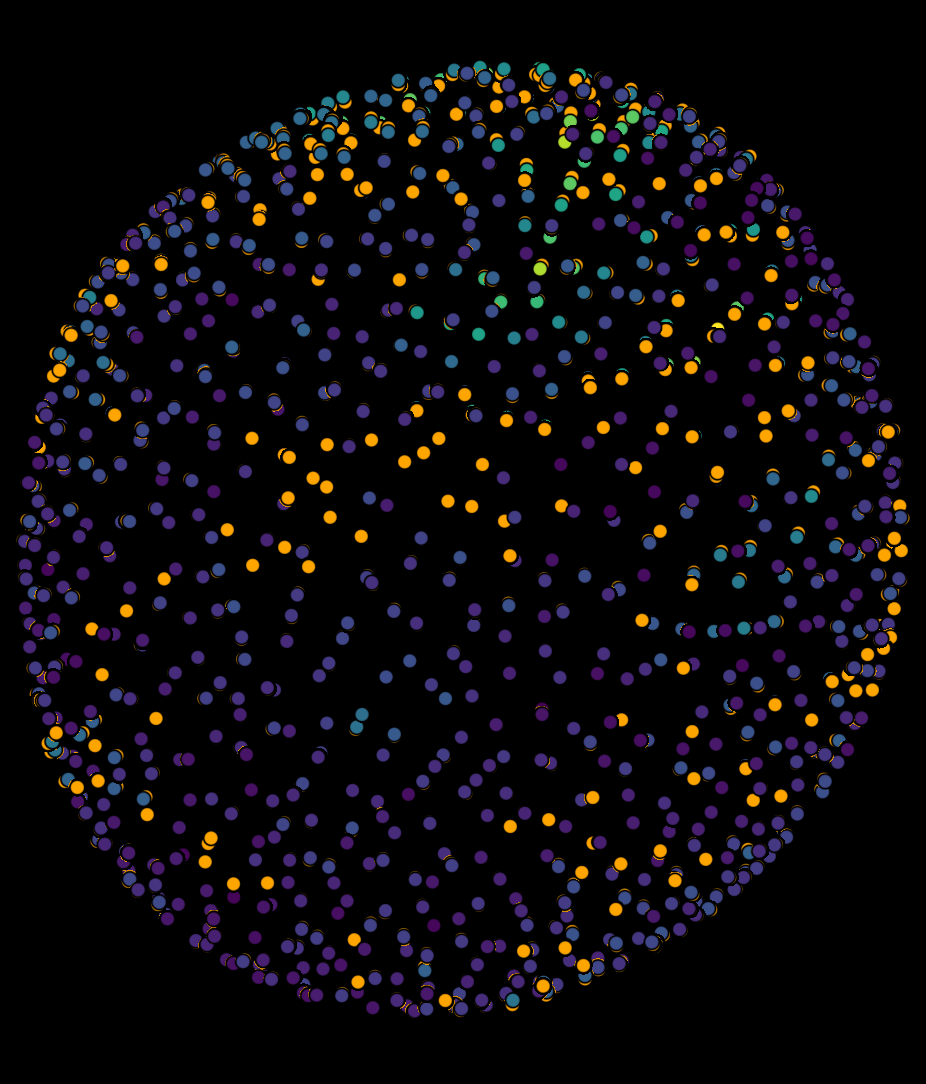

In [7]:
fitted_points_layer = viewer.add_points(fitted_points[0], **fitted_points[1])
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Measuring curvature

Another parameter you can retrieve from the obtained expansion with napari-stress, is the [mean curvature](https://en.wikipedia.org/wiki/Mean_curvature) at every point on the surface. Doing this requires two steps: A [lebedev quadrature](https://en.wikipedia.org/wiki/Lebedev_quadrature) of the surface expansion and the measurement of curvature at the obtained quadrature points. This requires the previously obtained coefficients:

In [8]:
coefficients = fitted_points[1]['metadata']['spherical_harmonics_coefficients']
quadrature_points, lebedev_fit = napari_stress.lebedev_quadrature(coefficients=coefficients, number_of_quadrature_points=500, use_minimal_point_set=False)
manifold = napari_stress.create_manifold(quadrature_points, lebedev_fit=lebedev_fit, max_degree=max_degree)

Lastly, you can use `napari_stress.measurements.calculate_mean_curvature_on_manifold()` to calculate the curvature based on the previously created manifold object. This function returns two dictionaries (`features` and `metadata`) which contain the mean curvature at each of the obtained quadrature as well as two measurements for globaly averaged curvature of the input pointcloud:

* The arithmetic average $H0_{arithmetic~avg}$: This is simply the averaged curvature at every point: $H0_{arithmetic~avg} = \frac{1}{N}\sum^N_{i=0} H_i$ where $H_i$ is the curvature at a given point.
* The surface integrated curvature $H0_{surf~int}$: This is the ratio of the area of the obtained expansion and the surface of a unit sphere $H0_{surf~int} = \frac{A_{manifold}}{A_{Sphere}}$

*Note*: The `features` dictionary contains the point-wise values (e.g., `Mean_curvature_at_lebedev_points`) whereas the `metadata` dictionary contains the globally computed parameters, such as $H0_{arithmetic~avg}$ and $H0_{surf~int}$. 

In [9]:
features, metadata = napari_stress.measurements.calculate_mean_curvature_on_manifold(manifold)

Text(0, 0.5, 'Occurrences [#]')

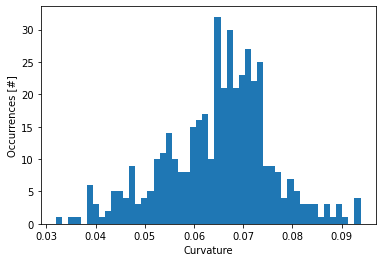

In [10]:
fig, ax = plt.subplots()
hist = ax.hist(features['Mean_curvature_at_lebedev_points'], bins=50)

ax.set_xlabel('Curvature')
ax.set_ylabel('Occurrences [#]')

In [11]:
print('Arithmetic average:',  metadata['H0_arithmetic_average'])
print('Surface integrated curvature:',  metadata['H0_surface_integral'])

Arithmetic average: 0.0649847267960451
Surface integrated curvature: 0.06626737254186338


Lastly, you can also visualize the curvature at every quadrature point in napari:

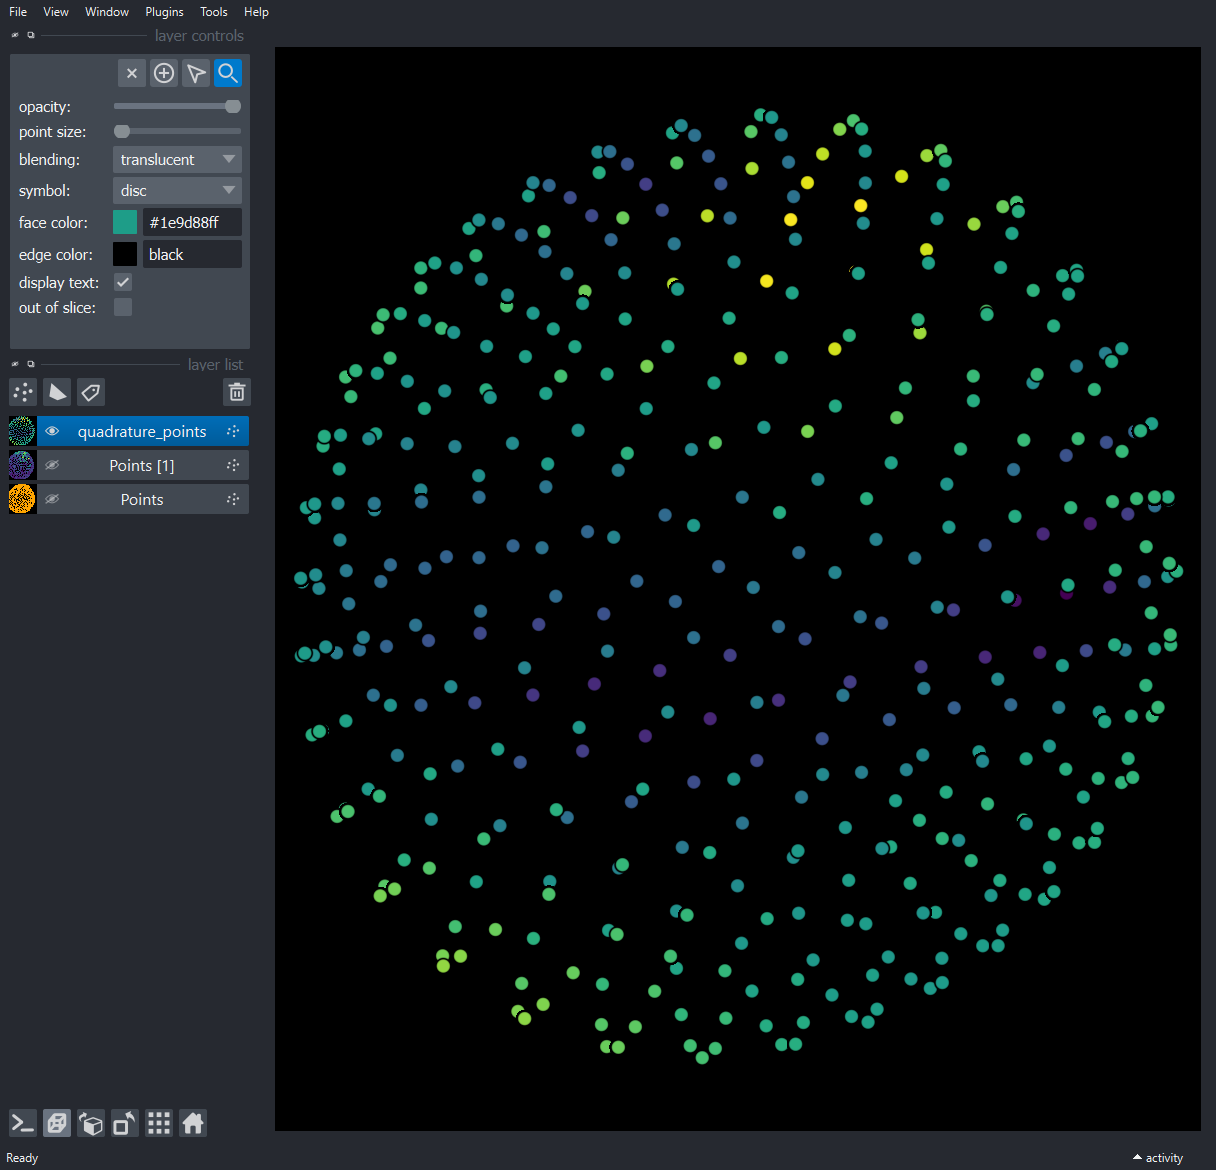

In [12]:
fitted_points_layer.visible = False
layer_raw.visible = False
viewer.add_points(quadrature_points, size=0.5, features=features, face_color='Mean_curvature_at_lebedev_points')
napari.utils.nbscreenshot(viewer)